C:\Users\acer\AppData\Local\Temp\ipykernel_22924\3741073585.py:85: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
C:\Users\acer\AppData\Local\Temp\ipykernel_22924\3741073585.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
C:\Users\acer\AppData\Local\Temp\ipykernel_22924\3741073585.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 1/20: Train Loss: 1.0990, Train Acc: 57.77%, Val Loss: 0.3186, Val Acc: 93.41%
Epoch 2/20: Train Loss: 0.5650, Train Acc: 79.89%, Val Loss: 0.2626, Val Acc: 91.21%
Epoch 3/20: Train Loss: 0.4806, Train Acc: 83.25%, Val Loss: 0.2603, Val Acc: 93.41%
Epoch 4/20: Train Loss: 0.4019, Train Acc: 85.87%, Val Loss: 0.2182, Val Acc: 94.51%
Epoch 5/20: Train Loss: 0.3559, Train Acc: 87.29%, Val Loss: 0.1719, Val Acc: 93.41%
Epoch 6/20: Train Loss: 0.3633, Train Acc: 86.89%, Val Loss: 0.1793, Val Acc: 94.51%
Epoch 7/20: Train Loss: 0.3078, Train Acc: 88.94%, Val Loss: 0.3520, Val Acc: 95.60%
Epoch 8/20: Train Loss: 0.3007, Train Acc: 89.50%, Val Loss: 0.2183, Val Acc: 94.51%
Epoch 9/20: Train Loss: 0.2611, Train Acc: 90.81%, Val Loss: 0.1545, Val Acc: 95.60%
Epoch 10/20: Train Loss: 0.2373, Train Acc: 91.61%, Val Loss: 0.0422, Val Acc: 100.00%
Epoch 11/20: Train Loss: 0.2323, Train Acc: 92.25%, Val Loss: 0.0346, Val Acc: 100.00%
Epoch 12/20: Train Loss: 0.2351, Train Acc: 91.75%, Val Loss:

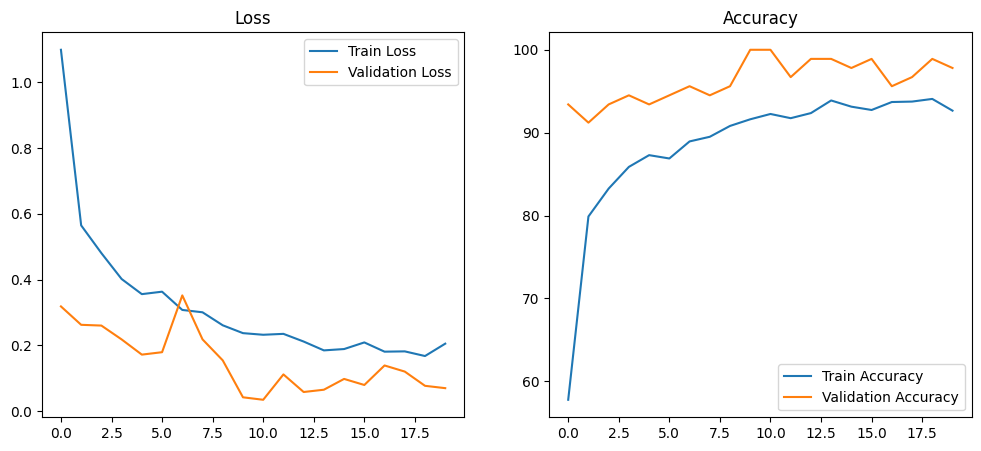

C:\Users\acer\AppData\Local\Temp\ipykernel_22924\3741073585.py:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Classification Report:

                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       0.95      1.00      0.97        18
              Healthy_Nail       1.00      1.00      1.00        20
           Onychogryphosis       1.00      0.92      0.96        12
               blue_finger       1.00      1.00      1.00         9
                  clubbing       1.00      0.94      0.97        16
                   pitting       0.94      1.00      0.97        16

                  accuracy                           0.98        91
                 macro avg       0.98      0.98      0.98        91
              weighted avg       0.98      0.98      0.98        91



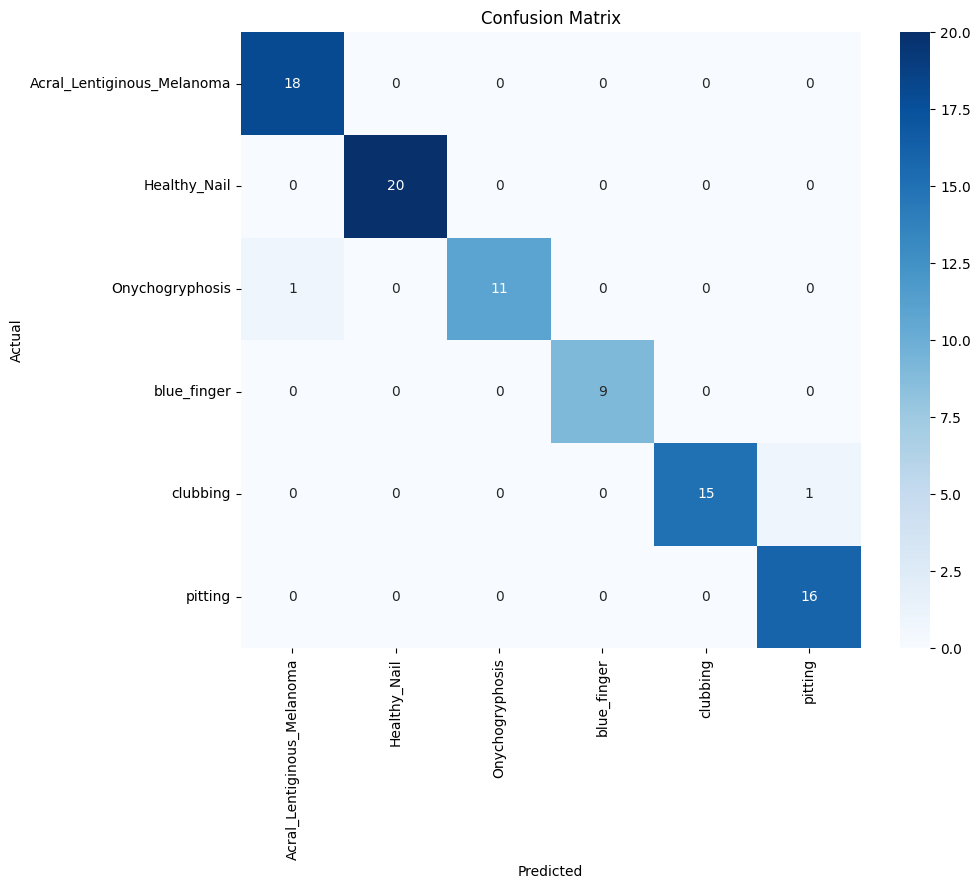

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset paths
train_dir = r"E:\nail disease\Final Dataset\train"
val_dir = r"E:\nail disease\Final Dataset\validation"

# Data transforms
input_size = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Choose model: ResNet50 or Vision Transformer
use_vit = False  # change to True for ViT

if use_vit:
    model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
    model.heads = nn.Sequential(
        nn.Linear(model.heads.head.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
else:
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    for name, param in model.named_parameters():
        if "layer3" in name or "layer4" in name or "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# AMP setup
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Training
epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    scheduler.step()

# Save model
model_type = "vit" if use_vit else "resnet50"
torch.save(model.state_dict(), f"{model_type}_nail_disease_model.pth")

# Accuracy/loss plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(inputs)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Using device: cuda


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [14:49<00:00,  3.80s/it]


Train Loss: 0.6807 | Acc: 0.8419


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.73s/it]


Val Loss: 0.1733 | Acc: 0.9780

Epoch 2/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [14:46<00:00,  3.79s/it]


Train Loss: 0.1885 | Acc: 0.9586


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]


Val Loss: 0.1019 | Acc: 0.9890

Epoch 3/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [14:48<00:00,  3.80s/it]


Train Loss: 0.1439 | Acc: 0.9623


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]


Val Loss: 0.0573 | Acc: 0.9890

Epoch 4/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [14:47<00:00,  3.79s/it]


Train Loss: 0.0861 | Acc: 0.9792


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.68s/it]


Val Loss: 0.0330 | Acc: 1.0000

Epoch 5/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [14:50<00:00,  3.81s/it]


Train Loss: 0.0591 | Acc: 0.9872


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.70s/it]


Val Loss: 0.0507 | Acc: 0.9890

Epoch 6/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [14:47<00:00,  3.79s/it]


Train Loss: 0.0688 | Acc: 0.9821


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.73s/it]


Val Loss: 0.0830 | Acc: 0.9670

Epoch 7/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [14:46<00:00,  3.79s/it]


Train Loss: 0.0452 | Acc: 0.9893


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.68s/it]


Val Loss: 0.0202 | Acc: 1.0000

Epoch 8/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [14:48<00:00,  3.80s/it]


Train Loss: 0.0482 | Acc: 0.9882


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.62s/it]


Val Loss: 0.0262 | Acc: 0.9890

Epoch 9/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [14:45<00:00,  3.78s/it]


Train Loss: 0.0419 | Acc: 0.9885


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]


Val Loss: 0.1975 | Acc: 0.9451

Epoch 10/10


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [14:48<00:00,  3.80s/it]


Train Loss: 0.0243 | Acc: 0.9941


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.79s/it]


Val Loss: 0.1341 | Acc: 0.9780


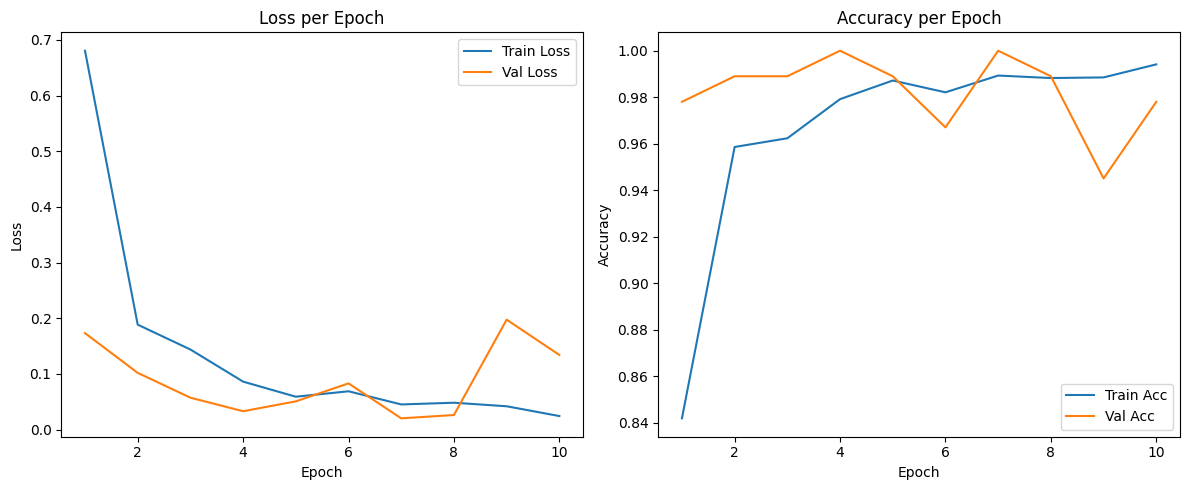

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Set the dataset path
DATASET_PATH = r"E:\nail disease\Final Dataset"

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ViT feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "validation"), transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Load pretrained ViT model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(train_dataset.classes),
    id2label={str(i): label for i, label in enumerate(train_dataset.classes)},
    label2id={label: i for i, label in enumerate(train_dataset.classes)},
)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# Metric function
def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return acc, precision, recall, f1

# Training
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc, train_prec, train_rec, train_f1 = calculate_metrics(all_labels, all_preds)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc, val_prec, val_rec, val_f1 = calculate_metrics(val_labels, val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

# Plot accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Acc')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')

plt.tight_layout()
plt.show()


C:\Users\acer\AppData\Local\Temp\ipykernel_12516\3006340962.py:85: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
C:\Users\acer\AppData\Local\Temp\ipykernel_12516\3006340962.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
C:\Users\acer\AppData\Local\Temp\ipykernel_12516\3006340962.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 1/50: Train Loss: 1.1097, Train Acc: 57.61%, Val Loss: 0.2925, Val Acc: 87.91%
Epoch 2/50: Train Loss: 0.5794, Train Acc: 78.85%, Val Loss: 0.2171, Val Acc: 94.51%
Epoch 3/50: Train Loss: 0.4847, Train Acc: 82.48%, Val Loss: 0.2692, Val Acc: 93.41%
Epoch 4/50: Train Loss: 0.4190, Train Acc: 84.83%, Val Loss: 0.2317, Val Acc: 94.51%
Epoch 5/50: Train Loss: 0.3698, Train Acc: 87.07%, Val Loss: 0.0637, Val Acc: 97.80%
Epoch 6/50: Train Loss: 0.3305, Train Acc: 88.62%, Val Loss: 0.1281, Val Acc: 95.60%
Epoch 7/50: Train Loss: 0.3227, Train Acc: 88.86%, Val Loss: 0.1098, Val Acc: 94.51%
Epoch 8/50: Train Loss: 0.2892, Train Acc: 89.90%, Val Loss: 0.2001, Val Acc: 95.60%
Epoch 9/50: Train Loss: 0.2635, Train Acc: 90.76%, Val Loss: 0.1352, Val Acc: 96.70%
Epoch 10/50: Train Loss: 0.2455, Train Acc: 91.75%, Val Loss: 0.0789, Val Acc: 96.70%
Epoch 11/50: Train Loss: 0.2211, Train Acc: 92.01%, Val Loss: 0.0857, Val Acc: 96.70%
Epoch 12/50: Train Loss: 0.2108, Train Acc: 92.52%, Val Loss: 0

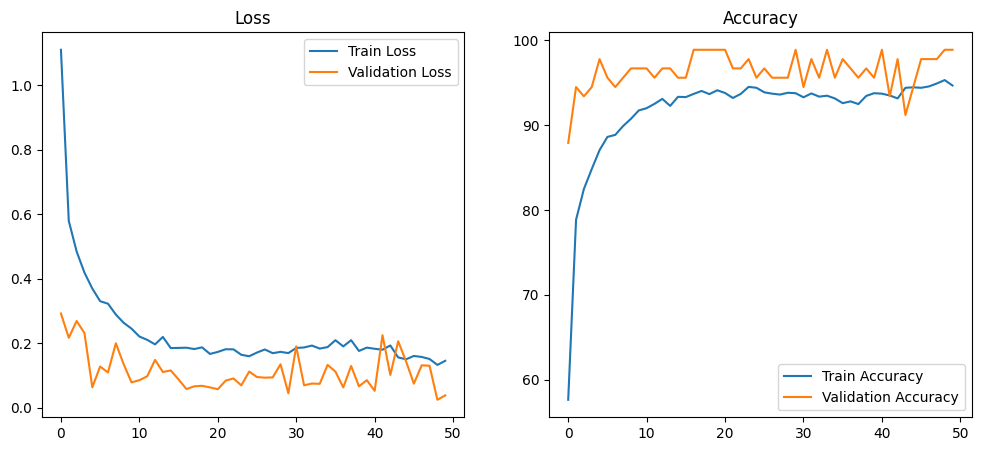

C:\Users\acer\AppData\Local\Temp\ipykernel_12516\3006340962.py:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Classification Report:

                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma       0.95      1.00      0.97        18
              Healthy_Nail       1.00      1.00      1.00        20
           Onychogryphosis       1.00      1.00      1.00        12
               blue_finger       1.00      1.00      1.00         9
                  clubbing       1.00      0.94      0.97        16
                   pitting       1.00      1.00      1.00        16

                  accuracy                           0.99        91
                 macro avg       0.99      0.99      0.99        91
              weighted avg       0.99      0.99      0.99        91



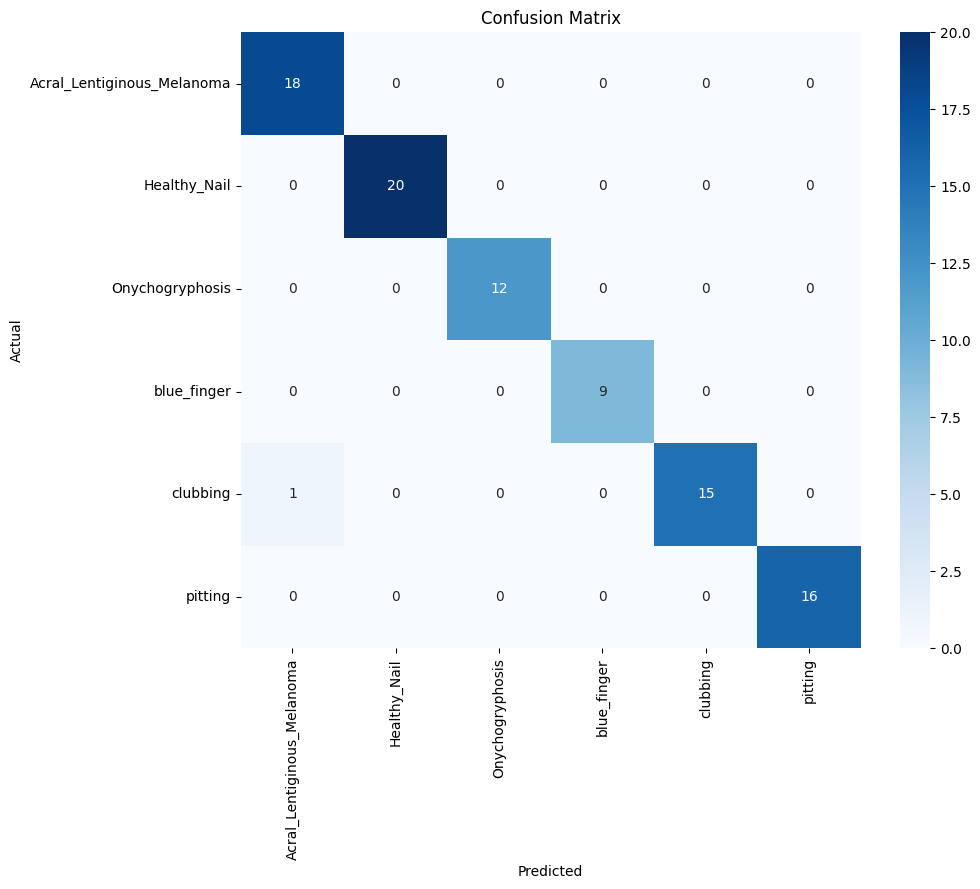

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset paths
train_dir = r"E:\nail disease\Final Dataset\train"
val_dir = r"E:\nail disease\Final Dataset\validation"

# Data transforms
input_size = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Choose model: ResNet50 or Vision Transformer
use_vit = False  # change to True for ViT

if use_vit:
    model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
    model.heads = nn.Sequential(
        nn.Linear(model.heads.head.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
else:
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    for name, param in model.named_parameters():
        if "layer3" in name or "layer4" in name or "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# AMP setup
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Training
epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    scheduler.step()

# Save model
model_type = "vit" if use_vit else "resnet50"
torch.save(model.state_dict(), f"{model_type}_nail_disease_model.pth")

# Accuracy/loss plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(inputs)
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.argmax(1).cpu().numpy())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Using device: cuda


C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:21<00:00,  1.65it/s]


Train Loss: 0.6876 | Acc: 0.8341


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.69s/it]


Val Loss: 0.1655 | Acc: 1.0000

Epoch 2/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.65it/s]


Train Loss: 0.2095 | Acc: 0.9498


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.93s/it]


Val Loss: 0.1342 | Acc: 0.9560

Epoch 3/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:29<00:00,  1.56it/s]


Train Loss: 0.1267 | Acc: 0.9696


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.72s/it]


Val Loss: 0.1252 | Acc: 0.9670

Epoch 4/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0962 | Acc: 0.9765


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.67s/it]


Val Loss: 0.0644 | Acc: 0.9780

Epoch 5/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.63it/s]


Train Loss: 0.0619 | Acc: 0.9858


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]


Val Loss: 0.0426 | Acc: 1.0000

Epoch 6/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.64it/s]


Train Loss: 0.0482 | Acc: 0.9890


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.62s/it]


Val Loss: 0.0976 | Acc: 0.9780

Epoch 7/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.65it/s]


Train Loss: 0.0677 | Acc: 0.9816


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.67s/it]


Val Loss: 0.0860 | Acc: 0.9670

Epoch 8/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0403 | Acc: 0.9904


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]


Val Loss: 0.0181 | Acc: 1.0000

Epoch 9/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0359 | Acc: 0.9901


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.60s/it]


Val Loss: 0.0999 | Acc: 0.9780

Epoch 10/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.65it/s]


Train Loss: 0.0396 | Acc: 0.9882


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.62s/it]


Val Loss: 0.0596 | Acc: 0.9890

Epoch 11/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.65it/s]


Train Loss: 0.0256 | Acc: 0.9939


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.62s/it]


Val Loss: 0.0271 | Acc: 0.9890

Epoch 12/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0265 | Acc: 0.9928


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]


Val Loss: 0.1559 | Acc: 0.9560

Epoch 13/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.63it/s]


Train Loss: 0.0282 | Acc: 0.9923


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.75s/it]


Val Loss: 0.0484 | Acc: 0.9890

Epoch 14/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.63it/s]


Train Loss: 0.0198 | Acc: 0.9941


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.58s/it]


Val Loss: 0.2460 | Acc: 0.9231

Epoch 15/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0309 | Acc: 0.9917


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.60s/it]


Val Loss: 0.1462 | Acc: 0.9670

Epoch 16/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0265 | Acc: 0.9928


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.65s/it]


Val Loss: 0.1435 | Acc: 0.9451

Epoch 17/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0281 | Acc: 0.9920


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.62s/it]


Val Loss: 0.0958 | Acc: 0.9560

Epoch 18/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0288 | Acc: 0.9912


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]


Val Loss: 0.0394 | Acc: 0.9890

Epoch 19/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.63it/s]


Train Loss: 0.0126 | Acc: 0.9971


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.67s/it]


Val Loss: 0.2780 | Acc: 0.9231

Epoch 20/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0082 | Acc: 0.9976


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.67s/it]


Val Loss: 0.1967 | Acc: 0.9451

Epoch 21/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.63it/s]


Train Loss: 0.0262 | Acc: 0.9925


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.64s/it]


Val Loss: 0.0916 | Acc: 0.9670

Epoch 22/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0232 | Acc: 0.9923


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.65s/it]


Val Loss: 0.0215 | Acc: 0.9890

Epoch 23/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.64it/s]


Train Loss: 0.0122 | Acc: 0.9971


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.82s/it]


Val Loss: 0.0848 | Acc: 0.9670

Epoch 24/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.64it/s]


Train Loss: 0.0144 | Acc: 0.9960


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]


Val Loss: 0.0903 | Acc: 0.9780

Epoch 25/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0185 | Acc: 0.9957


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.67s/it]


Val Loss: 0.0551 | Acc: 0.9780

Epoch 26/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.64it/s]


Train Loss: 0.0346 | Acc: 0.9885


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.60s/it]


Val Loss: 0.0484 | Acc: 0.9890

Epoch 27/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0164 | Acc: 0.9957


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.65s/it]


Val Loss: 0.0052 | Acc: 1.0000

Epoch 28/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0091 | Acc: 0.9968


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.58s/it]


Val Loss: 0.0101 | Acc: 1.0000

Epoch 29/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.65it/s]


Train Loss: 0.0290 | Acc: 0.9917


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.63s/it]


Val Loss: 0.0562 | Acc: 0.9780

Epoch 30/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.65it/s]


Train Loss: 0.0117 | Acc: 0.9965


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.70s/it]


Val Loss: 0.0704 | Acc: 0.9780

Epoch 31/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0210 | Acc: 0.9939


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.60s/it]


Val Loss: 0.0272 | Acc: 0.9890

Epoch 32/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0077 | Acc: 0.9976


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.63s/it]


Val Loss: 0.0301 | Acc: 0.9890

Epoch 33/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0069 | Acc: 0.9973


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.68s/it]


Val Loss: 0.0082 | Acc: 1.0000

Epoch 34/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.63it/s]


Train Loss: 0.0327 | Acc: 0.9909


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.68s/it]


Val Loss: 0.0164 | Acc: 1.0000

Epoch 35/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.64it/s]


Train Loss: 0.0098 | Acc: 0.9976


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.57s/it]


Val Loss: 0.1923 | Acc: 0.9560

Epoch 36/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.65it/s]


Train Loss: 0.0030 | Acc: 0.9989


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.69s/it]


Val Loss: 0.0509 | Acc: 0.9780

Epoch 37/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0017 | Acc: 0.9995


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.67s/it]


Val Loss: 0.0399 | Acc: 0.9780

Epoch 38/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.63it/s]


Train Loss: 0.0393 | Acc: 0.9890


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.67s/it]


Val Loss: 0.0157 | Acc: 1.0000

Epoch 39/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.63it/s]


Train Loss: 0.0133 | Acc: 0.9963


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.65s/it]


Val Loss: 0.0634 | Acc: 0.9780

Epoch 40/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.63it/s]


Train Loss: 0.0016 | Acc: 1.0000


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.65s/it]


Val Loss: 0.0562 | Acc: 0.9780

Epoch 41/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0176 | Acc: 0.9947


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.68s/it]


Val Loss: 0.0340 | Acc: 0.9890

Epoch 42/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0137 | Acc: 0.9949


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.69s/it]


Val Loss: 0.0344 | Acc: 0.9890

Epoch 43/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0025 | Acc: 0.9997


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]


Val Loss: 0.0322 | Acc: 0.9890

Epoch 44/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:23<00:00,  1.64it/s]


Train Loss: 0.0378 | Acc: 0.9899


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.65s/it]


Val Loss: 0.0476 | Acc: 0.9780

Epoch 45/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0226 | Acc: 0.9931


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.62s/it]


Val Loss: 0.0300 | Acc: 0.9890

Epoch 46/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:22<00:00,  1.64it/s]


Train Loss: 0.0228 | Acc: 0.9928


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.80s/it]


Val Loss: 0.0158 | Acc: 0.9890

Epoch 47/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:24<00:00,  1.62it/s]


Train Loss: 0.0020 | Acc: 1.0000


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]


Val Loss: 0.0085 | Acc: 1.0000

Epoch 48/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:21<00:00,  1.66it/s]


Train Loss: 0.0033 | Acc: 0.9992


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.67s/it]


Val Loss: 0.0565 | Acc: 0.9890

Epoch 49/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:21<00:00,  1.66it/s]


Train Loss: 0.0021 | Acc: 0.9997


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.65s/it]


Val Loss: 0.0852 | Acc: 0.9890

Epoch 50/50


Training: 100%|██████████████████████████████████████████████████████████████████████| 234/234 [02:21<00:00,  1.65it/s]


Train Loss: 0.0006 | Acc: 1.0000


Validation: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.71s/it]


Val Loss: 0.0815 | Acc: 0.9890


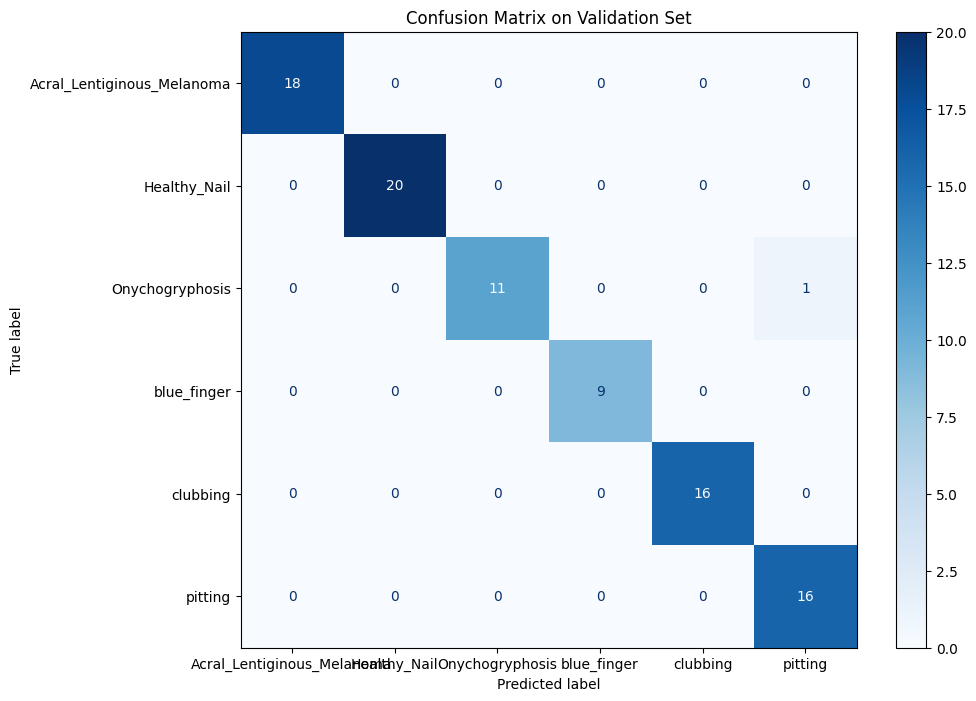

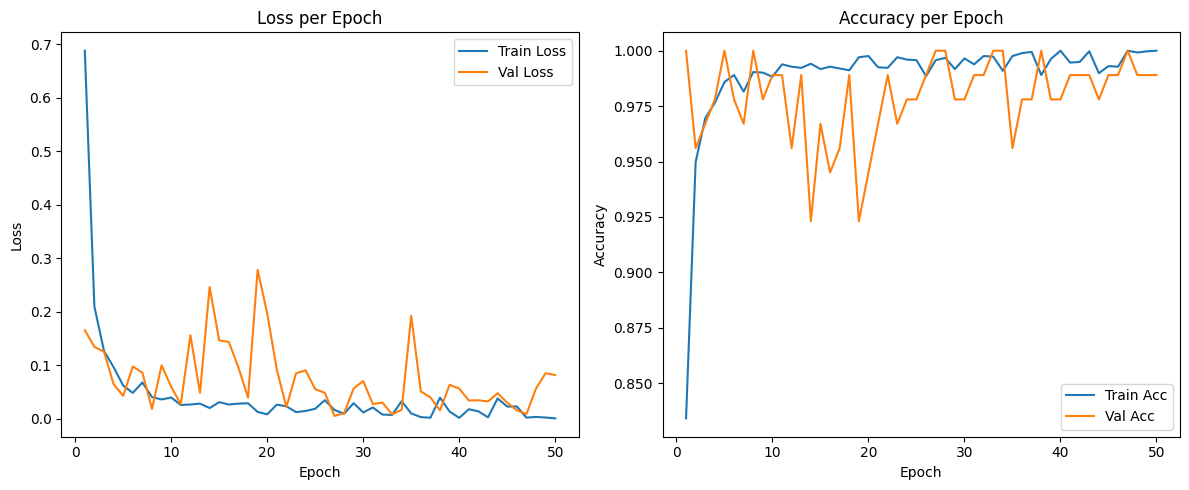

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

# Set the dataset path
DATASET_PATH = r"E:\nail disease\Final Dataset"

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ViT feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "validation"), transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Load pretrained ViT model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(train_dataset.classes),
    id2label={str(i): label for i, label in enumerate(train_dataset.classes)},
    label2id={label: i for i, label in enumerate(train_dataset.classes)},
)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# Metric function
def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return acc, precision, recall, f1

# Training
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc, train_prec, train_rec, train_f1 = calculate_metrics(all_labels, all_preds)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc, val_prec, val_rec, val_f1 = calculate_metrics(val_labels, val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

# Plot confusion matrix on validation set
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Set")
plt.show()

# Plot accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Acc')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')

plt.tight_layout()
plt.show()


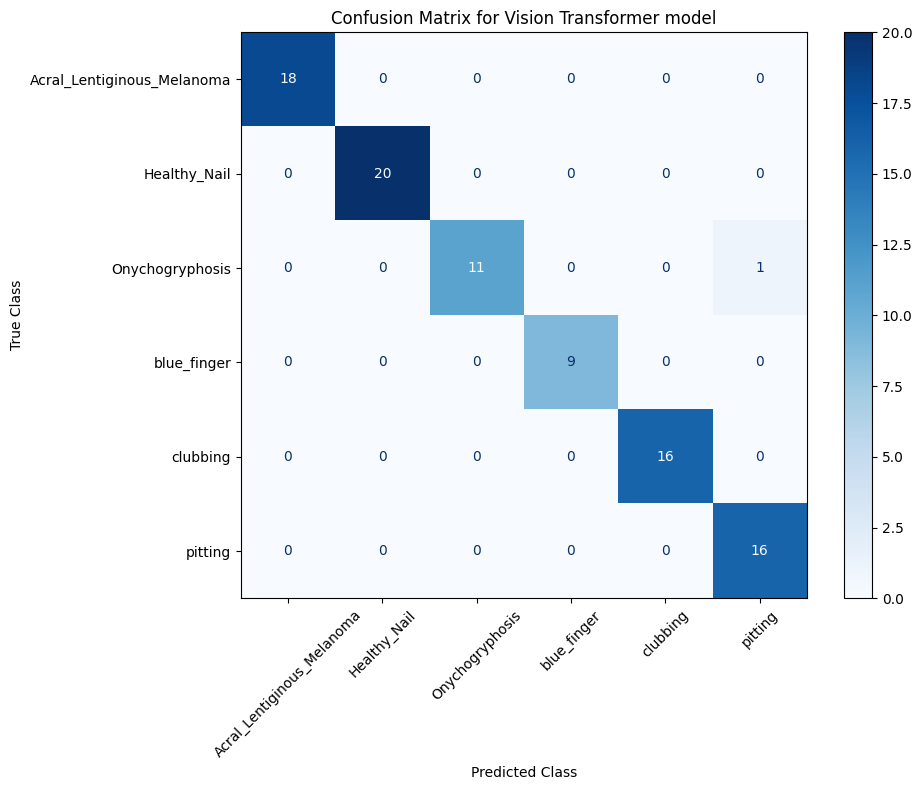

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Your manually set confusion matrix
cm = np.array([
    [18,  0,  0,  0,  0,  0],
    [ 0, 20,  0,  0,  0,  0],
    [ 0,  0, 11,  0,  0,  1],
    [ 0,  0,  0,  9,  0,  0],
    [ 0,  0,  0,  0, 16,  0],
    [ 0,  0,  0,  0,  0, 16]
])

# Automatically fetch class names from your dataset
class_labels = val_dataset.classes  # Ensure val_dataset is already defined

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vision Transformer model")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()


In [4]:
import os
import torch
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from tqdm import tqdm

# Set up path and device
DATASET_PATH = r"E:\nail disease\Final Dataset"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reload feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Transforms for validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load validation set
val_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "validation"), transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

# Reload the model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(val_dataset.classes),
    id2label={str(i): label for i, label in enumerate(val_dataset.classes)},
    label2id={label: i for i, label in enumerate(val_dataset.classes)},
)
model.to(device)
model.eval()

# Collect predictions and labels
val_preds, val_labels = [], []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Generating Predictions"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        preds = torch.argmax(outputs, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Generate classification report
report = classification_report(val_labels, val_preds, target_names=val_dataset.classes, digits=4)
print("Classification Report:\n")
print(report)


C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating Predictions: 100%|████████████████████████████████████████████████████████████| 6/6 [00:10<00:00,  1.75s/it]

Classification Report:

                            precision    recall  f1-score   support

Acral_Lentiginous_Melanoma     0.1053    0.1111    0.1081        18
              Healthy_Nail     0.1754    0.5000    0.2597        20
           Onychogryphosis     0.0000    0.0000    0.0000        12
               blue_finger     0.0000    0.0000    0.0000         9
                  clubbing     0.0000    0.0000    0.0000        16
                   pitting     0.0000    0.0000    0.0000        16

                  accuracy                         0.1319        91
                 macro avg     0.0468    0.1019    0.0613        91
              weighted avg     0.0594    0.1319    0.0785        91




C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie